# Melanoma Detection
- Student name : Thahura Naaz Shaik
- GITHub Link : 

## Problem Statement
Implement a Multiclass classification model using a custom convolutional neural network in TensorFlow.     


In [ ]:
#!pip install tensorflow

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

from skimage import io
import glob
import warnings
warnings.simplefilter('ignore')

# Data Reading/Data Understanding → Defining the path for train and test images 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Thahura-FJ/upgrad_AIML/MelanomaDetection/'
data_dir_train = pathlib.Path(root_path+"/Train")
data_dir_test = pathlib.Path(root_path+"/Test")

Mounted at /content/gdrive


In [ ]:
# data_dir_train = pathlib.Path("Downloads/melanomaDetection/Train")
# #data_dir_train = pathlib.Path("Downloads/melanomaDetection/Train_small")
# data_dir_test = pathlib.Path('Downloads/melanomaDetection/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
DATASET_PATH = data_dir_train


# Dataset Creation→ Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.

In [ ]:
data_dir = data_dir_train

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
n_channels=3

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset visualisation → Create a code to visualize one instance of all the nine classes present in the dataset 

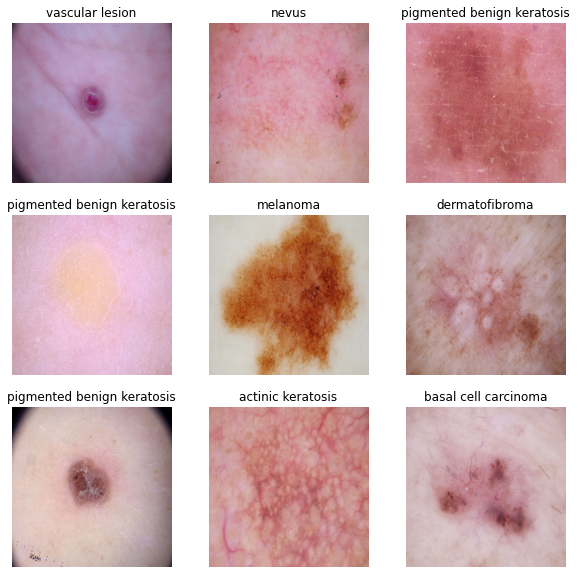

In [ ]:
from PIL import Image
from matplotlib.colors import NoNorm


plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    #bin_image = images[i][:, :, 0] > 100
    #plt.imshow(images[i].numpy().astype("uint8"),cmap='gray',norm=NoNorm())
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


This is a batch of 32 images of shape 180x180x3

The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

# <font color='blue'> Model 1 : Base model </font>
Create a CNN model, which can accurately detect 9 classes present in the dataset. 

While building the model, rescale images to normalize pixel values between (0,1).

Choose an appropriate optimiser and loss function for model training

Train the model for ~20 epochs

Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_train = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.98006546


In [ ]:
# model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                  input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_7 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 89, 89, 32)        0         
                                                      

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 447s 8s/step - loss: 144.6273 - accuracy: 0.1780 - val_loss: 2.1688 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 17s 271ms/step - loss: 2.1315 - accuracy: 0.1897 - val_loss: 2.0927 - val_accuracy: 0.2036
Epoch 3/20
56/56 [==============================] - 15s 247ms/step - loss: 2.0504 - accuracy: 0.2059 - val_loss: 2.0402 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 16s 249ms/step - loss: 2.0228 - accuracy: 0.2037 - val_loss: 2.0266 - val_accuracy: 0.2036
Epoch 5/20
56/56 [==============================] - 15s 246ms/step - loss: 2.0153 - accuracy: 0.1998 - val_loss: 2.0240 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 15s 248ms/step - loss: 2.0088 - accuracy: 0.2126 - val_loss: 2.0225 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 16s 250ms/step - loss: 2.0090 - accuracy: 0.1987 - val_loss: 2.0185 - val_accuracy: 0.2081

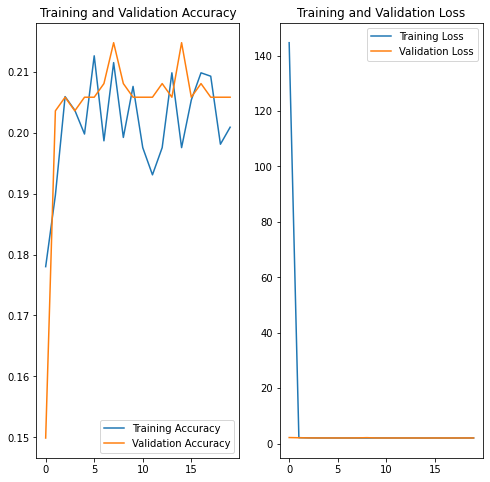

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## <font color='blue'> Model 1 Findings:
- The training and validation losses are decreasing which shows there are no hidden errors in the model
- The train accuracy is close to validation accuracy, which shows the model is not overfitting
- however, overall the train accuracy is low, we need to retry with proper preprosing techniques to learn efficiently</font> 

# <font color='red'>Model 2 : Data augmentation strategy</font>
Chose an appropriate data augmentation strategy to resolve underfitting/overfitting 

**Model Building & training on the augmented data:**

Create a CNN model, which can accurately detect 9 classes present in the dataset

Rescale images to normalize pixel values between (0,1).

Choose an appropriate optimiser and loss function for model training

Train the model for ~20 epochs

Write your findings after the model fit, see if the earlier issue is resolved or not?


In [ ]:
from skimage.transform import rescale
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=True,
    horizontal_flip=True,
    zoom_range=2.2)

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, multichannel=True, mode='constant')
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

In [ ]:
import numpy as np
import tensorflow as tf

# data generator with augmentation
class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, class_names= ['actinic keratosis','basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion'], 
                 batch_size=3, dim=(img_height, img_width), n_channels=n_channels, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(class_names):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(class_names)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > img_height and img.shape[1] > img_width:
                h, w, _ = img.shape
                img = img[int(h/2)-(img_height//2):int(h/2)+(img_height//2), int(w/2)-(img_width//2):int(w/2)+(img_width//2), : ]
            else:
                delete_rows.append(i)
                continue
            
            X[i,] = img
          
            # Store class
            y[i] = self.labels[ID]
        
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        # data augmentation
        if self.mode == 'train':
            aug_x = np.stack([datagen.random_transform(img) for img in X])
            X = np.concatenate([X, aug_x])
            y = np.concatenate([y, y])
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [ ]:
auc_logger = roc_callback()

In [ ]:
# checkpoint 
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

In [ ]:
# learning rate decay
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.001, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    # set lr on_train_begin
    def on_train_begin(self, logs={}):
        tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

    # change learning rate at the end of epoch
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(tf.keras.backend.get_value(self.model.optimizer.lr))
        tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)

In [ ]:
decay = DecayLR(base_lr=0.1)

In [ ]:
# training_generator = AugmentedDataGenerator('train', ablation=100)
# validation_generator = AugmentedDataGenerator('val', ablation=100)


training_generator = AugmentedDataGenerator('train')
validation_generator = AugmentedDataGenerator('val')


In [ ]:
# model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                  input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

In [ ]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.compile(optimizer='SGD',
#               loss='SparseCategoricalCrossentropy',
#               metrics=['accuracy'])

In [ ]:
epochs=20
history = model.fit(
  training_generator,
  validation_data=validation_generator,
  epochs=epochs,
  callbacks=[auc_logger, decay, checkpoint]
)

Epoch 1/20
595/595 [==============================] - ETA: 0s - loss: 2.0481 - accuracy: 0.1969
Val AUC for epoch0: 0.5

Epoch 1: val_auc improved from -inf to 0.50000, saving model to models/best_model.hdf5
595/595 [==============================] - 87s 146ms/step - loss: 2.0481 - accuracy: 0.1969 - val_loss: 2.0268 - val_accuracy: 0.1933 - val_auc: 0.5000
Epoch 2/20
595/595 [==============================] - ETA: 0s - loss: 2.0285 - accuracy: 0.1829
Val AUC for epoch1: 0.5

Epoch 2: val_auc did not improve from 0.50000
595/595 [==============================] - 88s 148ms/step - loss: 2.0285 - accuracy: 0.1829 - val_loss: 2.0256 - val_accuracy: 0.2067 - val_auc: 0.5000
Epoch 3/20
595/595 [==============================] - ETA: 0s - loss: 2.0225 - accuracy: 0.1908
Val AUC for epoch2: 0.5

Epoch 3: val_auc did not improve from 0.50000
595/595 [==============================] - 86s 145ms/step - loss: 2.0225 - accuracy: 0.1908 - val_loss: 2.0173 - val_accuracy: 0.2067 - val_auc: 0.5000
Ep

### Visualizing training results

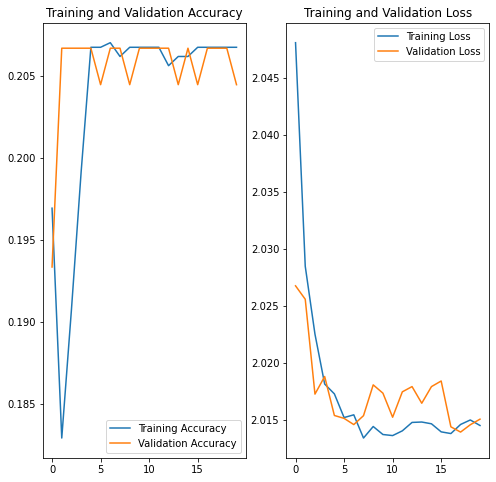

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## <font color='red'> Model 2 Findings:
- The training and validation losses are decreasing which shows there are no hidden errors in the model
- The train and validation accuracy are comparable, which means the model is not overfitting and is generalized.
- The overall train and validation accuracy has increased from model 1 , which is 0.2067 . 
- The AUC value is 0.5 which indicates good classification</font> 


#  <font color='green'>Model 3 : Addressing the data imbalance problem</font>

Class distribution: Examine the current class distribution in the training dataset 
- Least number of samples : **seborrheic keratosis with only 77 images in train set**
- Classes dominate the data in terms of the proportionate number of samples : **pigmented benign keratosis with 462 images**

In [76]:
D = {}
for i in class_names:
    disease_path = os.path.join(DATASET_PATH, i, '*')
    disease1 = glob.glob(disease_path)
    D.update({i : len(disease1)})
   

path_to_training_dataset = DATASET_PATH

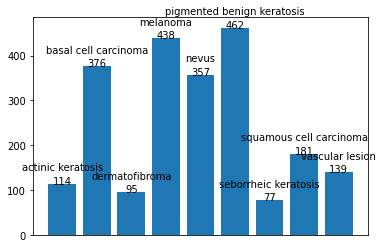

In [77]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+30, x[i], ha = 'center')
        plt.text(i, y[i], y[i], ha = 'center')
        
        
plt.bar(D.keys(), D.values())
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
addlabels(list(D.keys()),list(D.values()))
plt.show()



# Handling class imbalances: 
- Rectify class imbalances present in the training dataset with Augmentor library.
- https://augmentor.readthedocs.io/en/master/

In [79]:
#!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:

print(path_to_training_dataset)
import Augmentor
for i in class_names:
    path_to_training_dataset=os.path.join(DATASET_PATH, i)
    p = Augmentor.Pipeline(path_to_training_dataset)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

gdrive/My Drive/Thahura-FJ/upgrad_AIML/MelanomaDetection/Train
Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Thahura-FJ/upgrad_AIML/MelanomaDetection/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F574E580650>: 100%|██████████| 500/500 [00:21<00:00, 22.92 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Thahura-FJ/upgrad_AIML/MelanomaDetection/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F58082A5590>: 100%|██████████| 500/500 [00:18<00:00, 27.56 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Thahura-FJ/upgrad_AIML/MelanomaDetection/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F58E60FC310>: 100%|██████████| 500/500 [00:18<00:00, 27.54 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Thahura-FJ/upgrad_AIML/MelanomaDetection/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F574E6B6710>: 100%|██████████| 500/500 [01:21<00:00,  6.11 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Thahura-FJ/upgrad_AIML/MelanomaDetection/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F58666E1350>: 100%|██████████| 500/500 [01:21<00:00,  6.12 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Thahura-FJ/upgrad_AIML/MelanomaDetection/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5808274A50>: 100%|██████████| 500/500 [00:19<00:00, 26.09 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Thahura-FJ/upgrad_AIML/MelanomaDetection/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F58084B7490>: 100%|██████████| 500/500 [00:41<00:00, 11.92 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Thahura-FJ/upgrad_AIML/MelanomaDetection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5852E5AAD0>: 100%|██████████| 500/500 [00:17<00:00, 27.93 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Thahura-FJ/upgrad_AIML/MelanomaDetection/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F574E4FE410>: 100%|██████████| 500/500 [00:18<00:00, 27.01 Samples/s]


## Data is balanced after correction

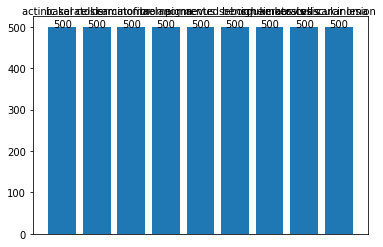

In [81]:
D = {}
for i in class_names:
    disease_path = os.path.join(DATASET_PATH, i, 'output','*')
    disease1 = glob.glob(disease_path)
    D.update({i : len(disease1)})
   

plt.bar(D.keys(), D.values())
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
addlabels(list(D.keys()),list(D.values()))
plt.show()

# Model Building & training on the rectified class imbalance data 
Create a CNN model, which can accurately detect 9 classes present in the dataset. 

While building the model, rescale images to normalize pixel values between (0,1).

Choose an appropriate optimiser and loss function for model training

Train the model for ~30 epochs

Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.


In [88]:
# model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                  input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

In [89]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [90]:
import numpy as np
import tensorflow as tf

# data generator with augmentation
class AugmentedDataGenerator_output(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, class_names= ['actinic keratosis','basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion'], 
                 batch_size=3, dim=(img_height, img_width), n_channels=n_channels, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(class_names):
            paths = glob.glob(os.path.join(DATASET_PATH, cls,'output' ,'*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(class_names)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > img_height and img.shape[1] > img_width:
                h, w, _ = img.shape
                img = img[int(h/2)-(img_height//2):int(h/2)+(img_height//2), int(w/2)-(img_width//2):int(w/2)+(img_width//2), : ]
            else:
                delete_rows.append(i)
                continue
            
            X[i,] = img
          
            # Store class
            y[i] = self.labels[ID]
        
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        # data augmentation
        if self.mode == 'train':
            aug_x = np.stack([datagen.random_transform(img) for img in X])
            X = np.concatenate([X, aug_x])
            y = np.concatenate([y, y])
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [91]:
training_generator = AugmentedDataGenerator_output('train', ablation=100)
validation_generator = AugmentedDataGenerator_output('val', ablation=100)

In [ ]:
epochs=30
history = model.fit(
  training_generator,
  validation_data=validation_generator,
  epochs=epochs,
  callbacks=[auc_logger, decay, checkpoint]
)

Epoch 1/30
300/300 [==============================] - ETA: 0s - loss: 3.4027 - accuracy: 0.0983
Val AUC for epoch0: 0.5

Epoch 1: val_auc did not improve from 0.50000
300/300 [==============================] - 74s 245ms/step - loss: 3.4027 - accuracy: 0.0983 - val_loss: 2.2006 - val_accuracy: 0.1111 - val_auc: 0.5000
Epoch 2/30
300/300 [==============================] - ETA: 0s - loss: 2.2066 - accuracy: 0.1028

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## <font color='green'> Model 3 Findings:</font> 
- The training and validation losses are decreasing which shows there are no hidden errors in the model
- The train accuracy is higher compared to validation accuracy, which shows the model is overfitting
- The train accuracy is also on the low